## Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score



# Load and preprocess data

In [2]:
def load_data(text_file):

    with open(text_file, encoding="utf-8") as file:
        sentences = []
        for line in file:
            if line != '\n':
                tuples = []
                for word in line.split():
                    w, tag = word.split('_')
                    tuples.append((w,tag))            
                sentences.append(tuples)
        
        return sentences



In [3]:
train_data = load_data(text_file="data/macmorpho-v3/macmorpho-train.txt")
test_data = load_data(text_file="data/macmorpho-v3/macmorpho-test.txt")

In [4]:
num_words = 0
num_tags = 0
words_set = set()
tags_set = set()
tag_count = {}

for sentence in train_data:
    for word, tag in sentence:
        words_set.add(word)
        tags_set.add(tag)
        
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

print("Dados de treinamento")
print(f"Número de frases: {len(train_data)}")
print(f"Tamanho do vocabulário: {len(words_set)}")
print(f"Número de tags: {len(tags_set)}")

Dados de treinamento
Número de frases: 37948
Tamanho do vocabulário: 52759
Número de tags: 26


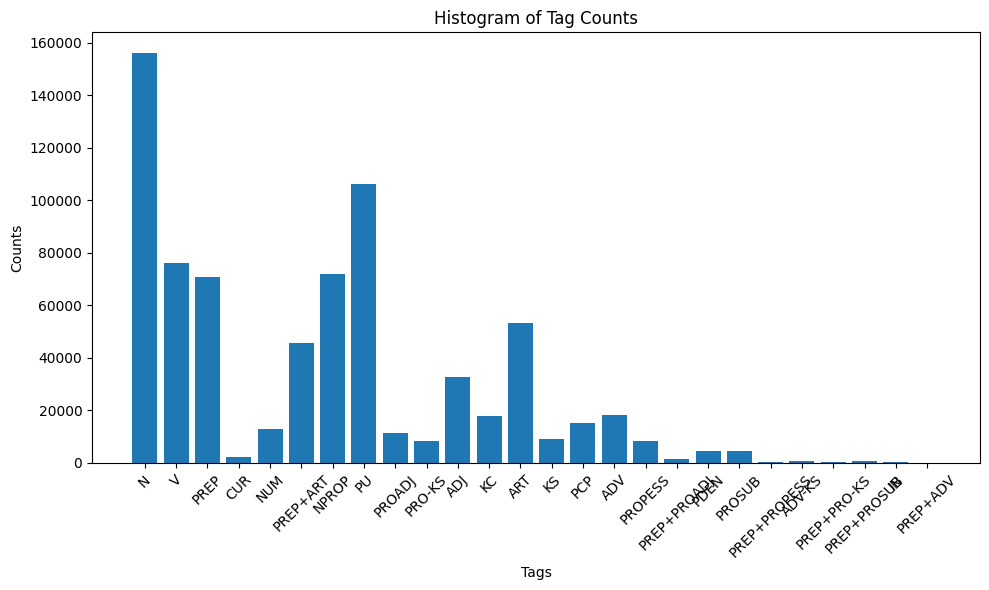

In [5]:
tags = list(tag_count.keys())
counts = list(tag_count.values())

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(tags, counts)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Histogram of Tag Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [6]:
num_words = 0
num_tags = 0
words_set = set()
tags_set = set()


for sentence in test_data:
    for word, tag in sentence:
        words_set.add(word)
        tags_set.add(tag)

print("Dados de teste")
print(f"Número de frases: {len(test_data)}")
print(f"Tamanho do vocabulário: {len(words_set)}")
print(f"Número de tags: {len(tags_set)}")

Dados de teste
Número de frases: 9987
Tamanho do vocabulário: 25140
Número de tags: 26


In [7]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", torch_dtype=torch.float16)
tokenizer

BertTokenizer(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [8]:
tags.append("<pad>")

tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}

## Pytorch dataset

In [9]:
class PosDataset(Dataset):

    """A custom dataset class for POS tagging using BERT tokenizer""" 

    def __init__(self, tagged_sentences, tokenizer: BertTokenizer, tag2idx, idx2tag):
        """Initializes the PosDataset instance.""" 
        
        sentences = []
        tags= []
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        self.max_seqlen = 0

        for sentence in tagged_sentences:
            words = [word_tag_tuple[0] for word_tag_tuple in sentence]
            sentence_tags = [word_tag_tuple[1] for word_tag_tuple in sentence]
            sentences.append(["[CLS]"] + words + ["[SEP]"])
            tags.append(["<pad>"] + sentence_tags + ["<pad>"])

        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):

        words, tags = self.sentences[idx], self.tags[idx]
        
        X, y = [], []

        word_head_masks = []
        for w, t in zip(words, tags):

            if w not in ["[CLS]", "[SEP]"]:
                tokens = self.tokenizer.tokenize(w)
            else:
                tokens = [w]
            
            word_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            
            word_head_mask = [1] + [0]*(len(tokens) - 1)
            t = [t] + ["<pad>"] * (len(tokens) - 1) 

            tags_idx = [self.tag2idx[tag] for tag in t]

            X.extend(word_ids)
            word_head_masks.extend(word_head_mask)
            y.extend(tags_idx)

        seqlen = len(y)

        words = " ".join(words)
        tags = " ".join(tags)
        return words, X, word_head_masks, tags, y, seqlen




In [10]:
pos_train_dataset = PosDataset(train_data, tokenizer, tag2idx, idx2tag)
pos_test_dataset = PosDataset(test_data, tokenizer, tag2idx, idx2tag)

Creating Pytorch Data Loader

In [11]:
def collate_function(batch):

    words = [sample[0] for sample in batch]
    is_heads = [sample[2] for sample in batch]
    tags = [sample[3] for sample in batch]
    seqlens = [sample[-1] for sample in batch]

    maxlen = max(seqlens)

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch]
    x = f(1, maxlen)
    y = f(-2, maxlen)

    return words, torch.LongTensor(x), is_heads, tags, torch.LongTensor(y), seqlens

In [12]:
train_dataloader = DataLoader(dataset=pos_train_dataset,
                            batch_size=8,
                            shuffle=True,
                            num_workers=4,
                            collate_fn=collate_function)
test_dataloader = DataLoader(dataset=pos_test_dataset,
                            batch_size=8,
                            shuffle=False,
                            num_workers=4,
                            collate_fn=collate_function)

In [ ]:
print( "Number of train batches",len(train_dataloader))
print( "Number of test batches",len(test_dataloader))

## Pytorch model

In [13]:
class FineTunedBert(nn.Module):
    def __init__(self, num_labels = None):
        super().__init__()

        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased")

        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, x):

        if self.training:
            self.bert.train()
            outputs = self.bert(x)
            out = outputs.last_hidden_state
        
        else:
            self.bert.eval()
            with torch.no_grad():
                outputs = self.bert(x)
                out = outputs.last_hidden_state

        
        logits = self.fc1(out)
        pred = logits.argmax(-1)

        return logits, pred

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
model = FineTunedBert(num_labels=len(tag2idx))

In [16]:
model.to(device)

FineTunedBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

## Training

In [17]:
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
epochs = 1

In [18]:
for epoch in range(epochs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        words, x, is_head, tags, y, seqlens = batch

        x = x.to(device)
        y = y.to(device)

        logits, pred = model(x)

        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print(f"Step: {i}, Loss: {loss.item()}")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step: 0, Loss: 3.4504833221435547
Step: 10, Loss: 0.8280138373374939
Step: 20, Loss: 0.6062771677970886
Step: 30, Loss: 0.5226663947105408
Step: 40, Loss: 0.24298302829265594
Step: 50, Loss: 0.299858421087265
Step: 60, Loss: 0.29446738958358765
Step: 70, Loss: 0.24812856316566467
Step: 80, Loss: 0.20825053751468658
Step: 90, Loss: 0.25187522172927856
Step: 100, Loss: 0.14485889673233032
Step: 110, Loss: 0.18319600820541382
Step: 120, Loss: 0.19505088031291962
Step: 130, Loss: 0.17247146368026733
Step: 140, Loss: 0.1575685441493988
Step: 150, Loss: 0.14485695958137512
Step: 160, Loss: 0.19753888249397278
Step: 170, Loss: 0.1701732873916626
Step: 180, Loss: 0.17427660524845123
Step: 190, Loss: 0.11922323703765869
Step: 200, Loss: 0.15020260214805603
Step: 210, Loss: 0.1068076342344284
Step: 220, Loss: 0.1459614634513855
Step: 230, Loss: 0.16925950348377228
Step: 240, Loss: 0.1395181268453598
Step: 250, Loss: 0.0890178456902504
Step: 260, Loss: 0.08612261712551117
Step: 270, Loss: 0.15993

KeyboardInterrupt: 

## Testing

In [21]:
model.eval()  

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        words, x, is_head, tags, y, seqlens = batch
        x = x.to(device)
        y = y.to(device)

        logits, pred = model(x)
        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)

        pred_labels = logits.argmax(dim=-1)

        predictions.extend(pred_labels.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')

In [22]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")

Test Accuracy: 0.9825
Test Precision: 0.9832


In [23]:
print("Saving model...")
torch.save(model, "model/pytorch_model.bin")

Saving model...


In [133]:
def predict_sentence(sentence, model, tokenizer: BertTokenizer, device, tag2idx, idx2tag):
    """
    Predict the POS tag for a sentence using a fine-tuned BERT model.
    """

    model.eval()
    words = sentence.split()

    inputs = tokenizer(words, 
                       return_tensors='pt', 
                       truncation=True,
                       is_split_into_words=True,
                       padding=True).to(device)
    
    x = inputs['input_ids']
    x = x.to(device)

    logits, _ =  model(x)
    

    logits = logits.view(-1, logits.shape[-1])
    pred_labels = logits.argmax(dim=-1)

    pred_labels = pred_labels.cpu().numpy()
    
    pad_idx = tag2idx["<pad>"]

    return [idx2tag[t] for t in pred_labels if t != pad_idx]

In [ ]:
word = 'O rato roeu a roupa do rei de Roma'
predicted_tag = predict_sentence(word, model, tokenizer, device, tag2idx, idx2tag)
print(word)
print(predicted_tag)

O rato roeu a roupa do rei de Roma
['ART', 'N', 'V', 'ART', 'N', 'PREP+ART', 'N', 'PREP', 'NPROP']
